In [2]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os

In [3]:
RECORDINGS_PATH = "/Users/habi/Downloads"
os.chdir(RECORDINGS_PATH)
df = pd.read_pickle("amd-df-01-29-10-41.pkl")


#convert label seriers to ints
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label']) 

print("count:")
print(df.label.value_counts())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
class_names = le.classes_

df.head()


count:
0    15
1    10
Name: label, dtype: int64
{'beep': 0, 'speech': 1}


,file_path,mfccs_40,chroma,mel,contrast,tonnetz,duration,label
0,normal_voice/290d0c83-d0f0-8b14-8572-fc312bac8...,"[-571.3539, 16.948996, 0.036792982, 3.9366152,...","[0.72958076, 0.79309595, 0.84281105, 0.8778919...","[0.00039769948, 0.0002510901, 0.0004602023, 0....","[63.26698310174349, 18.00875896970734, 20.4047...","[0.041440252211985384, 0.056259571675176506, 0...",9.72,0
2,normal_voice/8b8ee4ed-221b-6222-29f8-7af73a058...,"[-563.32983, 34.736164, -3.881335, 3.2611938, ...","[0.62028545, 0.66711754, 0.6961068, 0.72624785...","[0.00069938984, 0.00072266953, 0.0011561608, 0...","[37.63539460835902, 14.112737824241064, 19.313...","[-0.05345442303932088, -0.05267263574920788, -...",9.88,0
4,normal_voice/b2788eea-54c6-013b-e44b-5553306d8...,"[-550.4415, 31.06256, -2.6949258, 5.325177, 7....","[0.6395512, 0.69527966, 0.7418388, 0.7739457, ...","[0.00044606102, 0.00047681024, 0.00088301924, ...","[56.63914248512782, 17.576577716809165, 22.313...","[-0.056820924747716266, -0.009115021909210555,...",10.10,0
6,normal_voice/303b97cd-9744-d93e-98f4-260e05cf9...,"[-585.27545, 23.225786, -1.3455567, 2.8895302,...","[0.69682956, 0.75037056, 0.7902981, 0.82167166...","[0.00030930064, 0.00023839499, 0.0006629479, 0...","[50.44052064946122, 15.28866688664565, 18.6015...","[-0.00042013639869729164, -0.01525664277495028...",8.28,0
8,normal_voice/d136332c-e996-8811-9669-152bb8aa3...,"[-538.18506, 37.829617, -7.15697, 3.5153756, 6...","[0.66811734, 0.7184075, 0.76485026, 0.7948932,...","[0.00044168602, 0.0007633776, 0.0016972895, 0....","[52.408764871331236, 16.861522227291967, 20.64...","[-0.026444927871134883, -0.008184597665251129,...",13.20,0


In [4]:
#remove files with durations longer than 10 seconds
df = df.copy()
df = df.drop(df[ df['duration']>10].index)
df.reset_index(drop=True, inplace=True)

print(df.label.value_counts())


0    10
1     6
Name: label, dtype: int64


In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
import joblib
#from sklearn.externals import joblib
import datetime
import pickle


def print_classification_results(y_test, res):
    print(metrics.accuracy_score(y_test, res))
    print(metrics.classification_report(y_test, res))
    print(metrics.confusion_matrix(y_test, res))
    print("")

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def save_model(model, model_name):
  filename = "{}-{}.pkl".format(model_name, datetime.datetime.now().strftime("%Y%m%dT%H%M"))
  pickle.dump(model, open(filename, 'wb'))

  


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

def generateFeaturesLabels(features_list):
  total_features_len = np.sum([len(df[feature][0]) for feature in features_list])
  print("total number of features",total_features_len)
  features, labels = np.empty((0,total_features_len)), np.empty(0)
  for index, row in df.iterrows():
    a = []
    for feature in features_list:
      a.append(row[feature])
      
    features = np.vstack([features,np.hstack(a)])
    labels = np.append(labels, row["label"])
  return np.array(features), np.array(labels, dtype = np.int)

def train(features, model):
  X, y = generateFeaturesLabels(features)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  
  model.fit(X_train, y_train)
  print("Score:",model.score(X_test, y_test))
  
  cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
  print("cross_val_scores:", cross_val_scores)
  print("Accuracy: %0.2f (+/- %0.2f)" % (cross_val_scores.mean(), cross_val_scores.std() * 2))
  
  predictions = model.predict(X_test)

  print_classification_results(y_test, predictions)
  
  cm = metrics.confusion_matrix(y_test, predictions)
  plot_confusion_matrix(cm, class_names)
  
  print("*** Scaled ***")
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train_transformed = scaler.transform(X_train)
  scaled_model = model.fit(X_train_transformed, y_train)
  X_test_transformed = scaler.transform(X_test)
  print("scaled_model score:",model.score(X_test_transformed, y_test))
  
  return model
  
 

# Training

## OneVsRest

total number of features 40
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[3 0]
 [0 3]]

Confusion matrix, without normalization
[[3 0]
 [0 3]]
*** Scaled ***
scaled_model score: 0.8333333333333334


/var/folders/yz/lkm_ct5s5t74jpsnrc96_46h0000gn/T/ipykernel_32575/1660043069.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(features), np.array(labels, dtype = np.int)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=4000))

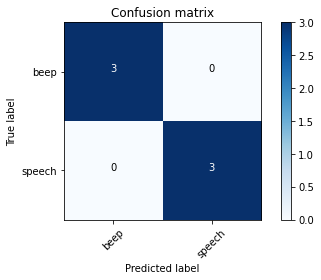

In [13]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
base_lr = LogisticRegression(solver='lbfgs', max_iter=4000)
ovr = OneVsRestClassifier(base_lr)
train(['mfccs_40'], ovr)

In [14]:
save_model(ovr,"ovr")

## RandomForest

total number of features 40
Score: 0.8333333333333334


/var/folders/yz/lkm_ct5s5t74jpsnrc96_46h0000gn/T/ipykernel_32575/1660043069.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(features), np.array(labels, dtype = np.int)


cross_val_scores: [1.  1.  0.4 1.  1. ]
Accuracy: 0.88 (+/- 0.48)
0.8333333333333334
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

[[3 0]
 [1 2]]

Confusion matrix, without normalization
[[3 0]
 [1 2]]
*** Scaled ***
scaled_model score: 0.8333333333333334


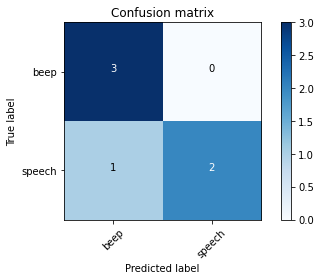

In [15]:
features_to_include = ['mfccs_40']
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50)
rf = train(features_to_include, model)

In [16]:
#working model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier(n_estimators = 100)
X = list(df.mfccs_40.values)
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

fit_model = rf.fit(X_train, y_train)

In [17]:
save_model(fit_model,"rf")

## XGBoost

In [19]:
import xgboost as xgb

features_to_include = ['mfccs_40']
model = xgb.XGBClassifier()
train(features_to_include, model)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Users/habi/opt/miniconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/habi/opt/miniconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


## LogisticRegression

total number of features 40
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[3 0]
 [0 3]]

Confusion matrix, without normalization
[[3 0]
 [0 3]]
*** Scaled ***
scaled_model score: 0.8333333333333334


/var/folders/yz/lkm_ct5s5t74jpsnrc96_46h0000gn/T/ipykernel_32575/1660043069.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(features), np.array(labels, dtype = np.int)


LogisticRegression(max_iter=200, solver='liblinear')

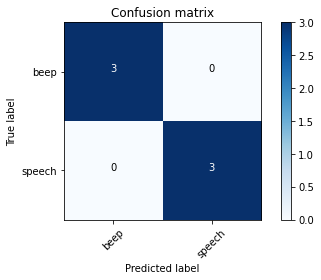

In [20]:
from sklearn.linear_model import LogisticRegression

features_to_include = ['mfccs_40']
logisticRegr = LogisticRegression(solver='liblinear', max_iter=200)
train(features_to_include, logisticRegr)

## SVM

total number of features 40
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[3 0]
 [0 3]]

Confusion matrix, without normalization
[[3 0]
 [0 3]]
*** Scaled ***
scaled_model score: 1.0


/var/folders/yz/lkm_ct5s5t74jpsnrc96_46h0000gn/T/ipykernel_32575/1660043069.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(features), np.array(labels, dtype = np.int)


SVC()

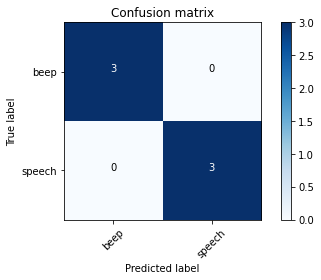

In [21]:
from sklearn import svm
svm = svm.SVC(gamma='scale')
features_to_include = ['mfccs_40']
train(features_to_include, svm)

#Save Model

In [22]:
import pickle
import datetime
filename = "rf-{}.pkl".format(datetime.datetime.now().strftime("%Y%m%dT%H%M"))
pickle.dump(rf, open(filename, 'wb'))